<a href="https://colab.research.google.com/github/lilz827/final-project-303-3/blob/main/Model_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve

In [47]:
data = pd.read_csv('stats_unique_no_missing.csv')
data.head()

,Unnamed: 0,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,...,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65,drafted
0,4589,Pooh Williams,Utah St.,WAC,32,64.0,108.3,18.1,53.0,53.33,...,0.4688,1.3750,1.8438,2.1875,0.5938,0.2188,8.7812,Combo G,7.300850,0.0
1,4590,Nick Rodgers,Butler,Horz,11,1.0,121.1,16.8,75.0,75.00,...,0.0000,0.0000,0.0000,0.0909,0.0000,0.0000,0.5455,Pure PG,12.267400,0.0
2,4591,Dana Smith,Longwood,ind,27,81.8,99.8,27.7,49.9,53.76,...,2.1481,4.9259,7.0741,2.4074,0.8148,0.4815,17.5556,Wing F,5.581250,0.0
3,4594,Carlos Strong,Boston University,AE,35,76.2,118.1,16.4,58.8,60.93,...,1.3429,3.2286,4.5714,1.8000,1.6571,0.4000,10.8571,Combo G,6.583070,0.0
4,4595,Sherrod Smith,Boston University,AE,29,9.5,60.7,6.9,8.3,14.93,...,0.1379,0.5862,0.7241,0.2069,0.1034,0.0345,0.1724,Wing G,0.844851,0.0


In [48]:
cols = list(data.columns)
categorical_cols = []
numerical_cols = []
for item in cols:
  if data[item].dtype == object:
    categorical_cols.append(item)
  else:
    numerical_cols.append(item)

In [49]:
categorical_cols

['player_name', 'team', 'conf', 'yr', 'ht', 'num', 'type', 'Unnamed: 64']

In [50]:
data = data.set_index('player_name')

In [51]:
data = data.drop(['Unnamed: 64', 'Unnamed: 65', 'rimmade+rimmiss', 'midmade+midmiss',
       'dunksmiss+dunksmade', 'num', 'type'], axis=1)
data_dummies = pd.get_dummies(data)

In [52]:
y = data_dummies.drafted
X = data_dummies.drop('drafted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=45)

In [55]:
params = {'bootstrap': [True],
          'n_estimators': [400, 500, 1000],
          'max_depth': [20, 30, 40],
          'max_features': [0.7, 1.0],
          'max_leaf_nodes':[100, 500, 1000],
          'max_samples': [0.2, 0.5, 0.7, 1.0]}

model_group = GridSearchCV(RandomForestClassifier(random_state=45, n_jobs=-1),
                           params, scoring='recall',
                           cv=3, n_jobs=-1, verbose=1)

model_group.fit(X_train, y_train)
print(model_group.best_score_, model_group.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
0.23955534969893466 {'bootstrap': True, 'max_depth': 30, 'max_features': 1.0, 'max_leaf_nodes': 500, 'max_samples': 1.0, 'n_estimators': 400}


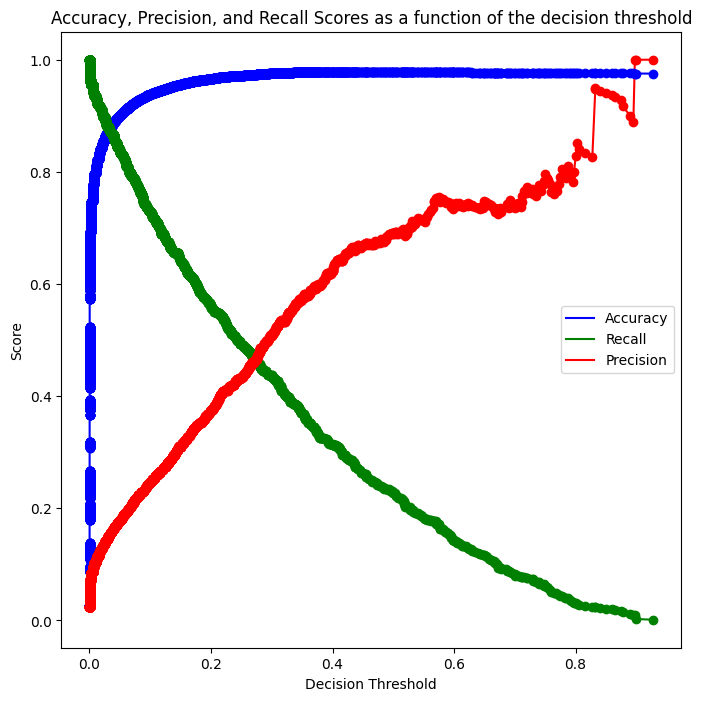

In [59]:
model = RandomForestClassifier(random_state=45, bootstrap=True,
                               n_estimators=400, max_features=1.0, max_samples=1.0,
                               max_depth=30, n_jobs=-1, max_leaf_nodes=500)
model.fit(X_train, y_train)

cross_val_ypred = cross_val_predict(model, X_train, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys)     

def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, 'b-', label='Accuracy')
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "r-", label="Precision")
    plt.plot(thresholds, accuracys, 'o', color='blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, precisions[:-1], "o", color='red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [69]:
desired_threshold = 0.05

ypred_prob_train = model.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

ypred_prob_test = model.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: ", accuracy_score(y_train, ypred_train))
print("Train Recall: ", recall_score(y_train, ypred_train))
print("Test Accuracy: ", accuracy_score(y_test, ypred_test))
print("Test Recall: ", recall_score(y_test, ypred_test))

Train Accuracy:  0.960389294403893
Train Recall:  1.0
Test Accuracy:  0.9006860980000974
Test Recall:  0.8209764918625678
